In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import wikipedia
from bs4 import BeautifulSoup
import requests
import warnings
warnings.filterwarnings('ignore')
import shap
from sklearn.model_selection import KFold

In [2]:
full_data = pd.read_csv("data/timesData.csv")

In [3]:
len(full_data)

2603

In [4]:
#Select top 200
data = full_data.loc[full_data["year"] == 2016]
data = data[:200].reset_index(drop=True)

In [5]:
#some basic EDA
print(data.columns)

for col in data.columns:
    print(data[col].unique())

data.describe()

Index(['world_rank', 'university_name', 'country', 'teaching', 'international',
       'research', 'citations', 'income', 'total_score', 'num_students',
       'student_staff_ratio', 'international_students', 'female_male_ratio',
       'year'],
      dtype='object')
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32' '33' '34' '35' '36' '37' '38' '=39' '41' '42' '43' '=44' '46'
 '=47' '49' '50' '51' '52' '53' '54' '55' '=56' '58' '59' '=60' '62' '63'
 '64' '=65' '67' '68' '69' '70' '71' '72' '73' '74' '75' '=76' '78' '79'
 '80' '81' '=82' '84' '85' '86' '87' '=88' '=90' '93' '=94' '97' '98'
 '=99' '=101' '=104' '=106' '108' '109' '=110' '112' '=113' '116' '117'
 '118' '119' '=120' '=123' '=125' '=127' '129' '130' '=131' '=133' '135'
 '136' '137' '=138' '140' '141' '142' '143' '=144' '146' '147' '148'
 '=149' '153' '154' '155' '156' '157' '=158' '160' '=161' '163' '=164'
 '=167' '=172'

 '64.8' '60.0' '99.8' '47.8' '61.1' '84.3' '69.5' '55.9' '64.9' '93.4']
[97.6 98.9 96.2 96.7 88.6 99.  91.9 88.5 95.  88.9 90.4 87.8 91.1 91.
 82.2 86.9 86.1 89.3 78.  85.2 88.8 80.6 77.2 78.4 84.5 75.8 81.1 77.4
 72.3 67.5 70.  75.5 73.2 76.9 81.2 69.6 72.1 69.8 66.  72.7 72.4 83.
 72.8 69.7 66.9 77.  68.2 55.7 77.3 47.7 61.3 68.1 64.7 66.1 62.8 55.6
 64.3 54.5 49.5 73.8 61.  63.1 58.9 51.6 51.9 55.2 72.2 58.5 56.9 61.9
 48.3 60.4 59.8 50.3 53.1 42.7 53.9 51.1 70.5 47.3 44.2 69.3 37.1 53.6
 46.6 40.  47.5 39.3 44.8 48.8 41.3 52.6 33.1 44.6 35.1 35.8 31.5 50.7
 41.8 48.1 46.1 56.3 43.6 45.5 32.7 57.7 47.1 42.1 42.5 38.7 56.8 39.7
 44.1 48.5 37.6 33.3 33.2 41.4 40.5 46.3 39.  44.7 51.2 37.2 36.3 50.5
 34.2 45.6 37.5 43.2 28.7 53.5 44.3 38.  30.9 45.8 27.9 30.8 66.7 22.3
 28.  37.3 23.7 27.8 58.  29.9 40.6 31.4 39.5 37.4 46.7 41.  38.5 43.9
 39.8 23.2 31.6 35.3 25.7 26.9 29.  38.1 40.8 29.3 23.9 26.7 52.4 22.2
 27.5 18.1 27.4 22.9]
[ 99.8  98.8  99.9  97.   99.7  99.3  96.7  91.1  99.2  

,teaching,research,citations,student_staff_ratio,year
count,200.00000,200.000000,200.00000,198.000000,200.0
mean,50.25000,53.905500,82.91500,17.207576,2016.0
std,16.28864,19.765154,12.79835,11.517808,0.0
min,25.00000,18.100000,8.60000,3.600000,2016.0
25%,38.50000,39.000000,76.67500,10.700000,2016.0
50%,47.40000,48.650000,84.70000,14.950000,2016.0
75%,59.95000,69.375000,92.20000,18.900000,2016.0
max,95.60000,99.000000,100.00000,85.800000,2016.0


In [6]:
data.corr()

,teaching,research,citations,student_staff_ratio,year
teaching,1.000000,0.894834,0.186377,-0.260841,NaN
research,0.894834,1.000000,0.150736,-0.085389,NaN
citations,0.186377,0.150736,1.000000,-0.226883,NaN
student_staff_ratio,-0.260841,-0.085389,-0.226883,1.000000,NaN
year,NaN,NaN,NaN,NaN,NaN


In [7]:
#Clean data
#remove commas in numbers
#Convert percentages to decimal
#convert F-M ratio to just Female percentage
#replace nans with mean

for i in data.index:
    data.at[i, 'teaching'] = float(data.at[i, 'teaching'])
    data.at[i, 'international'] = float(data.at[i, 'international'])
    data.at[i, 'research'] = float(data.at[i, 'research'])
    data.at[i, 'citations'] = float(data.at[i, 'citations'])
    data.at[i, 'total_score'] = float(data.at[i, 'total_score'])
    data.at[i, 'student_staff_ratio'] = float(data.at[i, 'student_staff_ratio'])
    
    if(not pd.isna(data.at[i, 'num_students'])):
        data.at[i, 'num_students'] = int(str(data.at[i, 'num_students']).replace(',', ''))
    

    data.at[i, 'international_students'] = float(str(data.at[i, 'international_students']).strip('%'))/100

    if(data.at[i, 'income'] == "-"):
        data.at[i, 'income'] = np.nan
    else:
        data.at[i, "income"] = float(data.at[i, "income"])
    
    if(not pd.isna(data.at[i, 'female_male_ratio'])):
        females = data.at[i, 'female_male_ratio'].split(" : ")[0]
        data.at[i, 'female_male_ratio'] = float(females)/100
        

data = data.fillna(data.mean())

In [8]:
for column in  ["teaching", "international", "research", "citations", "income", "total_score", "num_students", "student_staff_ratio", "international_students", "female_male_ratio"]:
    data[column] = data[column].fillna(data[column].mean())

In [9]:
#PART ONE: Regular LGBM with no extra data

#X columns (input)
X_cols = ["country", "teaching", "international", "research", "citations", "income", "num_students", "student_staff_ratio", "international_students", "female_male_ratio"]
y_col = "total_score"

In [10]:
#split into training (80%), and test
#not enough data for a validation set
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [11]:
X_train = train[X_cols]
y_train = train[y_col].astype('float64')
X_test = test[X_cols]
y_test = test[y_col].astype('float64')


X_train["country"] = X_train["country"].astype('category')
X_test["country"] = X_test["country"].astype('category')

X_train["income"] = X_train["income"].astype('float64')
X_test["income"] = X_test["income"].astype('float64')

X_train["num_students"] = X_train["num_students"].astype('int32')
X_test["num_students"] = X_test["num_students"].astype('int32')

X_train["female_male_ratio"] = X_train["female_male_ratio"].astype('float64')
X_test["female_male_ratio"] = X_test["female_male_ratio"].astype('float64')

X_train["international_students"] = X_train["international_students"].astype('float64')
X_test["international_students"] = X_test["international_students"].astype('float64')

In [12]:
lgbm_train = lgbm.Dataset(X_train, y_train)
lgbm_eval = lgbm.Dataset(X_test, y_test, reference=lgbm_train)

In [13]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgbm.train(params,
                lgbm_train,
                num_boost_round=30,
                valid_sets=lgbm_eval,
                early_stopping_rounds=5)

Starting training...
[1]	valid_0's l2: 99.7426	valid_0's l1: 8.0566
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 93.8302	valid_0's l1: 7.85859
[3]	valid_0's l2: 87.6922	valid_0's l1: 7.62226
[4]	valid_0's l2: 82.8727	valid_0's l1: 7.44289
[5]	valid_0's l2: 76.8149	valid_0's l1: 7.18087
[6]	valid_0's l2: 71.2399	valid_0's l1: 6.95479
[7]	valid_0's l2: 66.9708	valid_0's l1: 6.77249
[8]	valid_0's l2: 63.665	valid_0's l1: 6.63394
[9]	valid_0's l2: 59.173	valid_0's l1: 6.41443
[10]	valid_0's l2: 55.6229	valid_0's l1: 6.24359
[11]	valid_0's l2: 52.8517	valid_0's l1: 6.1066
[12]	valid_0's l2: 48.8555	valid_0's l1: 5.85873
[13]	valid_0's l2: 46.5485	valid_0's l1: 5.72958
[14]	valid_0's l2: 42.9725	valid_0's l1: 5.51065
[15]	valid_0's l2: 39.7451	valid_0's l1: 5.30267
[16]	valid_0's l2: 37.1259	valid_0's l1: 5.13044
[17]	valid_0's l2: 34.774	valid_0's l1: 4.97236
[18]	valid_0's l2: 32.6115	valid_0's l1: 4.81897
[19]	valid_0's l2: 30.7232	valid_0's l1: 4.68433
[2

In [14]:
print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The mse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

Starting predicting...
The rmse of prediction is: 4.114697923573288


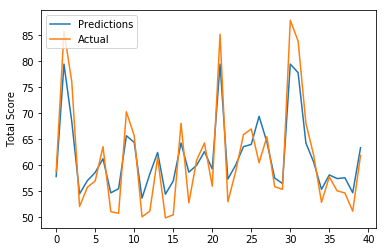

In [15]:
plt.plot(y_pred, label="Predictions")
plt.plot(y_test.values, label="Actual")
plt.legend(loc='upper left')
plt.ylabel('Total Score')
plt.show()

In [16]:
#PART TWO: Add in Wikipedia data: Type of university

In [17]:
uni_type = dict()
for uni in data["university_name"]:
    search_results = wikipedia.search(uni)
    res = requests.get("https://en.wikipedia.org/wiki/" + search_results[0])
    soup = BeautifulSoup(res.content, "html.parser")
    tables = soup.find_all("table", class_="infobox vcard")
    for row in tables[0].findAll("tr"):
        cells = row.findAll(["th", "td"])
        if(len(cells) > 1):
            if (cells[0].get_text() == "Type"):
                uni_type[uni] = cells[1].get_text()
                break

In [18]:
for key in uni_type:
    uni_type[key] = uni_type[key].lower()
    if ("public" in uni_type[key] or "state" in uni_type[key] or "national" in uni_type[key]):
        uni_type[key] = "public"
    elif ("private" in uni_type[key] or "autonomous" in uni_type[key] or "independent" in uni_type[key]):
        uni_type[key] = "private"
    else:
        uni_type[key] = "private" 

In [20]:
#create new type column
data['type'] = data["university_name"].map(uni_type)

In [21]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

X_cols = ["type", "country", "teaching", "international", "research", "citations", "income", "num_students", "student_staff_ratio", "international_students", "female_male_ratio"]
y_col = "total_score"
X_train = train[X_cols]
y_train = train[y_col].astype('float64')
X_test = test[X_cols]
y_test = test[y_col].astype('float64')

#Note: for type, we let LGBM automatically handle the NaN values however it wants
X_train["type"] = X_train["type"].astype('category')
X_test["type"] = X_test["type"].astype('category')

X_train["country"] = X_train["country"].astype('category')
X_test["country"] = X_test["country"].astype('category')

X_train["income"] = X_train["income"].astype('float64')
X_test["income"] = X_test["income"].astype('float64')

X_train["num_students"] = X_train["num_students"].astype('int32')
X_test["num_students"] = X_test["num_students"].astype('int32')

X_train["female_male_ratio"] = X_train["female_male_ratio"].astype('float64')
X_test["female_male_ratio"] = X_test["female_male_ratio"].astype('float64')

X_train["international_students"] = X_train["international_students"].astype('float64')
X_test["international_students"] = X_test["international_students"].astype('float64')

In [22]:
lgbm_train = lgbm.Dataset(X_train, y_train)
lgbm_eval = lgbm.Dataset(X_test, y_test, reference=lgbm_train)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgbm.train(params,
                lgbm_train,
                num_boost_round=30,
                valid_sets=lgbm_eval,
                early_stopping_rounds=5)

Starting training...
[1]	valid_0's l2: 100.776	valid_0's l1: 8.07636
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 94.7823	valid_0's l1: 7.87815
[3]	valid_0's l2: 88.4139	valid_0's l1: 7.64704
[4]	valid_0's l2: 83.5205	valid_0's l1: 7.46778
[5]	valid_0's l2: 77.0938	valid_0's l1: 7.18718
[6]	valid_0's l2: 71.4924	valid_0's l1: 6.94531
[7]	valid_0's l2: 66.2197	valid_0's l1: 6.70694
[8]	valid_0's l2: 62.7912	valid_0's l1: 6.54566
[9]	valid_0's l2: 58.5732	valid_0's l1: 6.33635
[10]	valid_0's l2: 55.0887	valid_0's l1: 6.16771
[11]	valid_0's l2: 52.1922	valid_0's l1: 6.02733
[12]	valid_0's l2: 49.5843	valid_0's l1: 5.89397
[13]	valid_0's l2: 45.8912	valid_0's l1: 5.66844
[14]	valid_0's l2: 42.8551	valid_0's l1: 5.49658
[15]	valid_0's l2: 40.3333	valid_0's l1: 5.34012
[16]	valid_0's l2: 37.6048	valid_0's l1: 5.16699
[17]	valid_0's l2: 35.3123	valid_0's l1: 5.02344
[18]	valid_0's l2: 32.9839	valid_0's l1: 4.85957
[19]	valid_0's l2: 31.2504	valid_0's l1: 4.741

Starting predicting...
The rmse of prediction is: 4.060788523661373


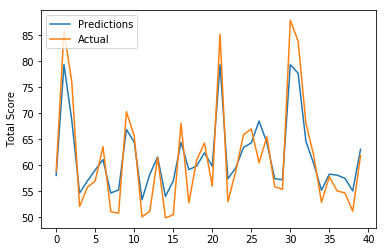

In [23]:
print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The mse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

plt.plot(y_pred, label="Predictions")
plt.plot(y_test.values, label="Actual")
plt.legend(loc='upper left')
plt.ylabel('Total Score')
plt.show()

In [24]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_train)

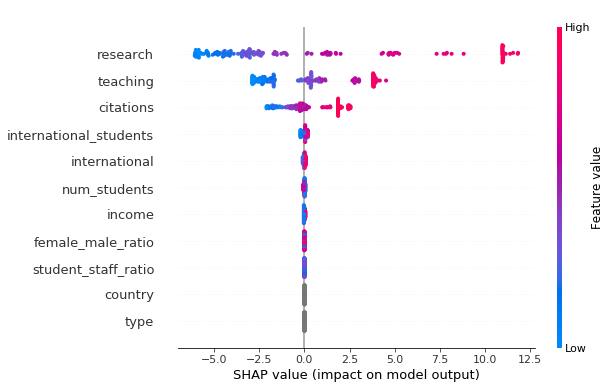

In [25]:
shap.summary_plot(shap_values, X_train)

In [26]:
#PART THREE: k-fold
X_cols = ["type", "country", "teaching", "international", "research", "citations", "income", "num_students", "student_staff_ratio", "international_students", "female_male_ratio"]
y_col = "total_score"

num_splits = 5
skf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
average_score = []
for train_index, test_index in skf.split(data[X_cols], data[y_col]):
    train = data.iloc[train_index, :]
    X_train = train[X_cols]
    y_train = train[y_col].astype('float64')
    
    test = data.iloc[test_index, :]
    X_test = test[X_cols]
    y_test = test[y_col].astype('float64')
    
    
    #Note: for "type", we let LGBM automatically handle the NaN values however it wants
    X_train["type"] = X_train["type"].astype('category')
    X_test["type"] = X_test["type"].astype('category')
    
    X_train["country"] = X_train["country"].astype('category')
    X_test["country"] = X_test["country"].astype('category')

    X_train["income"] = X_train["income"].astype('float64')
    X_test["income"] = X_test["income"].astype('float64')

    X_train["num_students"] = X_train["num_students"].astype('int32')
    X_test["num_students"] = X_test["num_students"].astype('int32')

    X_train["female_male_ratio"] = X_train["female_male_ratio"].astype('float64')
    X_test["female_male_ratio"] = X_test["female_male_ratio"].astype('float64')

    X_train["international_students"] = X_train["international_students"].astype('float64')
    X_test["international_students"] = X_test["international_students"].astype('float64')
    
    lgbm_train = lgbm.Dataset(X_train, y_train)
    lgbm_eval = lgbm.Dataset(X_test, y_test, reference=lgbm_train)
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': 50,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    }

    print('Starting training...')
    # train
    gbm = lgbm.train(params,
                    lgbm_train,
                    num_boost_round=30,
                    valid_sets=lgbm_eval,
                    early_stopping_rounds=5)
    
    print('Starting predicting...')
    # predict
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    # eval
    print('The mse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
    print("===============================================================")
    
    average_score.append([y_pred])

average_score = np.mean(average_score, axis=0)[0]

# eval
print('Final MSE:', mean_squared_error(y_test, average_score) ** 0.5)

Starting training...
[1]	valid_0's l2: 99.9171	valid_0's l1: 8.053
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 93.0722	valid_0's l1: 7.79909
[3]	valid_0's l2: 87.2307	valid_0's l1: 7.58802
[4]	valid_0's l2: 81.9545	valid_0's l1: 7.39824
[5]	valid_0's l2: 76.7688	valid_0's l1: 7.19339
[6]	valid_0's l2: 70.6564	valid_0's l1: 6.91033
[7]	valid_0's l2: 65.1468	valid_0's l1: 6.64142
[8]	valid_0's l2: 60.6645	valid_0's l1: 6.42012
[9]	valid_0's l2: 56.9236	valid_0's l1: 6.24556
[10]	valid_0's l2: 53.1997	valid_0's l1: 6.05609
[11]	valid_0's l2: 49.2464	valid_0's l1: 5.82016
[12]	valid_0's l2: 45.6958	valid_0's l1: 5.59602
[13]	valid_0's l2: 42.506	valid_0's l1: 5.40254
[14]	valid_0's l2: 39.4725	valid_0's l1: 5.21774
[15]	valid_0's l2: 37.3745	valid_0's l1: 5.08967
[16]	valid_0's l2: 35.6375	valid_0's l1: 4.97854
[17]	valid_0's l2: 33.9291	valid_0's l1: 4.84721
[18]	valid_0's l2: 32.5074	valid_0's l1: 4.7462
[19]	valid_0's l2: 30.931	valid_0's l1: 4.6138
[20

[22]	valid_0's l2: 39.6814	valid_0's l1: 4.57812
[23]	valid_0's l2: 39.02	valid_0's l1: 4.50934
[24]	valid_0's l2: 37.815	valid_0's l1: 4.39489
[25]	valid_0's l2: 36.7479	valid_0's l1: 4.28622
[26]	valid_0's l2: 35.4804	valid_0's l1: 4.21292
[27]	valid_0's l2: 34.0258	valid_0's l1: 4.09763
[28]	valid_0's l2: 33.1868	valid_0's l1: 4.02609
[29]	valid_0's l2: 31.9427	valid_0's l1: 3.91858
[30]	valid_0's l2: 31.2308	valid_0's l1: 3.85366
Did not meet early stopping. Best iteration is:
[30]	valid_0's l2: 31.2308	valid_0's l1: 3.85366
Starting predicting...
The rmse of prediction is: 5.588456002488568
Final RMSE: 4.381496201516047


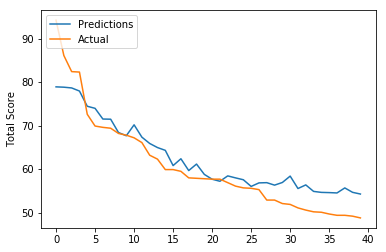

In [27]:
plt.plot(average_score, label="Predictions")
plt.plot(y_test.values, label="Actual")
plt.legend(loc='upper left')
plt.ylabel('Total Score')
plt.show()